# Introduction

Name : I Gusti Agung Istri Ratu Apsari Dewi

Batch : 02

Objectives : Sentiment Analysis towards News Headlines using RNN

___

Dataset collected from webscraping stock related news headline at [finviz](https://finviz.com/news.ashx) around Sept 22 - Oct 3, 2021.

**Data feature:**
1. ticker = company related
2. date = news published date
3. time = news published time
4. headline 
5. neg = negative polarity score (calculated using vader)
6. neu = neutral polarity score (calculated using vader)
7. pos = positive polarity score (calculated using vader)
8. compound = the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive). The more Compound score closer to +1, the higher the positivity of the text.
___


# Import Libraries

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
pip install wordcloud

In [ ]:
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import plotly.express as px

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score


# Data Loading

In [ ]:
news_data = pd.read_csv("parsed_and_scored_news.csv")
news_data.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,MSFT,2021-10-03,11:55PM,Dow Jones Futures: Market Rally Attempt Begins...,0.000,0.789,0.211,0.4939
1,MSFT,2021-10-03,06:00PM,SoftBank Is Cutting More Deals With Fewer Staf...,0.130,0.870,0.000,-0.1280
2,MSFT,2021-10-03,02:40PM,Is Microsoft Stock A Buy Before Software Giant...,0.000,1.000,0.000,0.0000
3,MSFT,2021-10-03,06:05AM,These 5 Dividend Stocks Pay $71 Billion a Year...,0.123,0.877,0.000,-0.1027
4,MSFT,2021-10-02,07:00AM,A Newly Public Stock That's Beating Microsoft ...,0.273,0.727,0.000,-0.4588


Above dataset did not contain sentiment label, therefore we will add additional column to describe its sentiment and class.

In [ ]:
conditions = [
    (news_data['compound'] < 0.0),
    (news_data['compound'] == 0.0),
    (news_data['compound'] > 0.0)
]

values = [0,1,2]
values2 = ['negative','neutral','positive']

news_data['label'] = np.select(conditions, values)
news_data['sentiment'] = np.select(conditions, values2)

news_data.head()

,ticker,date,time,headline,neg,neu,pos,compound,label,sentiment
0,MSFT,2021-10-03,11:55PM,Dow Jones Futures: Market Rally Attempt Begins...,0.000,0.789,0.211,0.4939,2,positive
1,MSFT,2021-10-03,06:00PM,SoftBank Is Cutting More Deals With Fewer Staf...,0.130,0.870,0.000,-0.1280,0,negative
2,MSFT,2021-10-03,02:40PM,Is Microsoft Stock A Buy Before Software Giant...,0.000,1.000,0.000,0.0000,1,neutral
3,MSFT,2021-10-03,06:05AM,These 5 Dividend Stocks Pay $71 Billion a Year...,0.123,0.877,0.000,-0.1027,0,negative
4,MSFT,2021-10-02,07:00AM,A Newly Public Stock That's Beating Microsoft ...,0.273,0.727,0.000,-0.4588,0,negative


In [ ]:
news_data.to_csv('news_data.csv', index=False)

In [ ]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker     500 non-null    object 
 1   date       500 non-null    object 
 2   time       500 non-null    object 
 3   headline   500 non-null    object 
 4   neg        500 non-null    float64
 5   neu        500 non-null    float64
 6   pos        500 non-null    float64
 7   compound   500 non-null    float64
 8   label      500 non-null    int64  
 9   sentiment  500 non-null    object 
dtypes: float64(4), int64(1), object(5)
memory usage: 39.2+ KB


In [ ]:
news_data.isnull().sum()

ticker       0
date         0
time         0
headline     0
neg          0
neu          0
pos          0
compound     0
label        0
sentiment    0
dtype: int64

In [ ]:
news_data.duplicated().sum()

0

From above data information, there are no missing values and duplicated values.

# Data Preprocessing

## Create data train, validation and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(news_data['headline'], news_data['label'], test_size= 0.2, random_state=42)

In [ ]:
def prepare_target(y_train, y_test):
  y_train_enc = to_categorical(y_train)
  y_test_enc = to_categorical(y_test)
  return y_train_enc, y_test_enc

y_train, y_test = prepare_target(y_train, y_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train.to_numpy(), y_train, test_size=0.2, random_state=42)

In [ ]:
round(sum([len(i.split()) for i in X_train])/len(X_train))

11

## Basic Text Preprocessing

1. Lowering headline text

In [ ]:
news_data['text_lower'] = news_data['headline'].str.lower()
news_data[['headline','text_lower']].head()

,headline,text_lower
0,Dow Jones Futures: Market Rally Attempt Begins...,dow jones futures: market rally attempt begins...
1,SoftBank Is Cutting More Deals With Fewer Staf...,softbank is cutting more deals with fewer staf...
2,Is Microsoft Stock A Buy Before Software Giant...,is microsoft stock a buy before software giant...
3,These 5 Dividend Stocks Pay $71 Billion a Year...,these 5 dividend stocks pay $71 billion a year...
4,A Newly Public Stock That's Beating Microsoft ...,a newly public stock that's beating microsoft ...


2. Removing punctuation from headline

In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

news_data["text_wo_punct"] = news_data["text_lower"].apply(lambda text: remove_punctuation(text))
news_data[['headline','text_wo_punct']].head()

,headline,text_wo_punct
0,Dow Jones Futures: Market Rally Attempt Begins...,dow jones futures market rally attempt begins ...
1,SoftBank Is Cutting More Deals With Fewer Staf...,softbank is cutting more deals with fewer staf...
2,Is Microsoft Stock A Buy Before Software Giant...,is microsoft stock a buy before software giant...
3,These 5 Dividend Stocks Pay $71 Billion a Year...,these 5 dividend stocks pay 71 billion a year ...
4,A Newly Public Stock That's Beating Microsoft ...,a newly public stock thats beating microsoft t...


3. Removing stop words

In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

news_data["text_wo_stop"] = news_data["text_wo_punct"].apply(lambda text: remove_stopwords(text))
news_data[['headline','text_wo_stop']].head()

,headline,text_wo_stop
0,Dow Jones Futures: Market Rally Attempt Begins...,dow jones futures market rally attempt begins ...
1,SoftBank Is Cutting More Deals With Fewer Staf...,softbank cutting deals fewer staff ever
2,Is Microsoft Stock A Buy Before Software Giant...,microsoft stock buy software giants septemberq...
3,These 5 Dividend Stocks Pay $71 Billion a Year...,5 dividend stocks pay 71 billion year combined...
4,A Newly Public Stock That's Beating Microsoft ...,newly public stock thats beating microsoft luc...


4. Converting word to its root form

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

news_data["text_lemmatized"] = news_data["text_wo_stop"].apply(lambda text: lemmatize_words(text))
news_data[['headline','text_lemmatized']].head()

,headline,text_lemmatized
0,Dow Jones Futures: Market Rally Attempt Begins...,dow jones future market rally attempt begin 7 ...
1,SoftBank Is Cutting More Deals With Fewer Staf...,softbank cut deal few staff ever
2,Is Microsoft Stock A Buy Before Software Giant...,microsoft stock buy software giant septemberqu...
3,These 5 Dividend Stocks Pay $71 Billion a Year...,5 dividend stock pay 71 billion year combine s...
4,A Newly Public Stock That's Beating Microsoft ...,newly public stock thats beat microsoft lucrat...


5. Removing numbers from text

In [ ]:
news_data['text_no_num'] = news_data['text_lemmatized'].str.replace('\d+', '')
news_data[['headline','text_no_num']].head()

,headline,text_no_num
0,Dow Jones Futures: Market Rally Attempt Begins...,dow jones future market rally attempt begin s...
1,SoftBank Is Cutting More Deals With Fewer Staf...,softbank cut deal few staff ever
2,Is Microsoft Stock A Buy Before Software Giant...,microsoft stock buy software giant septemberqu...
3,These 5 Dividend Stocks Pay $71 Billion a Year...,dividend stock pay billion year combine shar...
4,A Newly Public Stock That's Beating Microsoft ...,newly public stock thats beat microsoft lucrat...


## Text Vectorization

Creating layer that lowercases text, splits on whitespace, strips punctuation, and outputs integer vocab indices.

In [ ]:
# setup text vect
max_vocab_length = 4000
max_length = 12

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)

In [ ]:
text_vectorization.adapt(X_train)

In [ ]:
text_vectorization.get_vocabulary()[0]

''

In [ ]:
sample_news = "These 5 Dividend Stocks Pay $71 Billion a Year, Combined, to Their Shareholders"
text_vectorization([sample_news])

<tf.Tensor: shape=(1, 12), dtype=int64, numpy=
array([[  28,   54,  261,    4,   80, 1221,   90,    6,   75, 1109,    2,
         619]])>

In [ ]:
import random

In [ ]:
random_news = random.choice(X_train)
print(f"Teks Asli : {random_news}\n")
text_vectorization([random_news])

Teks Asli : Amazon Launches Home Robot, Tesla Works On Its Own: Ready For The Robot Revolution?



<tf.Tensor: shape=(1, 12), dtype=int64, numpy=array([[ 13,  84, 247, 106, 103, 547,  11,  20, 226, 748,  12,   7]])>

## Text Embedding

Creating embedding layer so each word is represented by some real-valued vector.

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)

embedding

In [ ]:
print(f"Teks Asli : {random_news}\n")

sample_embedded = embedding(text_vectorization([random_news]))
sample_embedded.shape

Teks Asli : Amazon Launches Home Robot, Tesla Works On Its Own: Ready For The Robot Revolution?



TensorShape([1, 12, 128])

# Exploratory Data Analysis

## 1. Headline News Sentiment Overview

In [ ]:
temp = news_data.groupby('sentiment').count()['headline'].reset_index().sort_values(by='headline',ascending=False)
temp.style.background_gradient(cmap='Blues')

,sentiment,headline
2,positive,212
1,neutral,170
0,negative,118


In [ ]:
fig = px.funnel(temp, x='headline', y='sentiment')
fig.show()

Collected news headline have high positive sentiment and low negative sentiment, meanwhile neutral sentiment is in between. Both sentiment is well balanced.

## 2. Sentiment Overview by day in World's Top 5 Company (Sept 22 - Oct 3, 2021)

In [ ]:
news_data['ticker'].unique()

array(['MSFT', 'AMZN', 'GOOG', 'AAPL', 'FB'], dtype=object)

In [ ]:
msft = news_data[news_data['ticker']=='MSFT'].groupby(['sentiment','date']).agg({'label':'count'}).reset_index()
aapl = news_data[news_data['ticker']=='AAPL'].groupby(['sentiment','date']).agg({'label':'count'}).reset_index()
goog = news_data[news_data['ticker']=='GOOG'].groupby(['sentiment','date']).agg({'label':'count'}).reset_index()
fb = news_data[news_data['ticker']=='FB'].groupby(['sentiment','date']).agg({'label':'count'}).reset_index()
amzn = news_data[news_data['ticker']=='AMZN'].groupby(['sentiment','date']).agg({'label':'count'}).reset_index()

In [ ]:
fig = px.line(msft, x='date', y='label', color='sentiment', title='Microsoft Headline News Sentiment', color_discrete_sequence=['red','gray','green'])
fig.show()

In 28-29 Sept, positive and neutral sentiment mentioning Microsoft was increasing. Positive sentiment continues to spark on 30 Sept, and starting to subside 2 days after. 

In [ ]:
fig = px.line(amzn, x='date', y='label', color='sentiment', title='Amazon Headline News Sentiment', color_discrete_sequence=['red','gray','green'])
fig.show()

For Amazon, news related to them seems lessen from 23 news in 29 Sept to 8 news in 3 Oct. Sentiment proportion in day by day is similar during that period of time.

In [ ]:
fig = px.line(goog, x='date', y='label', color='sentiment', title='Google Headline News Sentiment', color_discrete_sequence=['red','gray','green'])
fig.show()

For Google, news related to them seems lessen from 37 news in 29 Sept to 7 news in 3 Oct. Negative sentiment proportion is decreasing and became lowest in number on 3 Oct.

In [ ]:
fig = px.line(fb, x='date', y='label', color='sentiment', title='Facebook Headline News Sentiment', color_discrete_sequence=['red','gray','green'])
fig.show()

In [ ]:
news_data.loc[(news_data['ticker']=='FB')&(news_data['date']=='2021-09-30')&(news_data['sentiment']=='negative')].head(5)

,ticker,date,time,headline,neg,neu,pos,compound,label,sentiment,text_lower,text_wo_punct,text_wo_stop,text_lemmatized,text_no_num
426,FB,2021-09-30,09:46PM,Celebrity Instagram content linked to negative...,0.291,0.709,0.000,-0.5719,0,negative,celebrity instagram content linked to negative...,celebrity instagram content linked to negative...,celebrity instagram content linked negative fe...,celebrity instagram content link negative feel...,celebrity instagram content link negative feel...
427,FB,2021-09-30,09:30PM,Celebrity Instagram content linked to negative...,0.291,0.709,0.000,-0.5719,0,negative,celebrity instagram content linked to negative...,celebrity instagram content linked to negative...,celebrity instagram content linked negative fe...,celebrity instagram content link negative feel...,celebrity instagram content link negative feel...
429,FB,2021-09-30,06:58PM,Facebook Was Back in Front of Congress Today. ...,0.231,0.769,0.000,-0.5106,0,negative,facebook was back in front of congress today. ...,facebook was back in front of congress today t...,facebook back front congress today hearing ugly,facebook back front congress today hear ugly,facebook back front congress today hear ugly
430,FB,2021-09-30,05:27PM,Facebook Was Back in Front of Congress Today. ...,0.231,0.769,0.000,-0.5106,0,negative,facebook was back in front of congress today. ...,facebook was back in front of congress today t...,facebook back front congress today hearing ugly,facebook back front congress today hear ugly,facebook back front congress today hear ugly
431,FB,2021-09-30,03:42PM,Facebook Safety Chief Faces Criticism in Senat...,0.248,0.513,0.239,-0.0258,0,negative,facebook safety chief faces criticism in senat...,facebook safety chief faces criticism in senat...,facebook safety chief faces criticism senate h...,facebook safety chief face criticism senate he...,facebook safety chief face criticism senate he...


Facebook seems to be having issues in 30 Sept, positive sentiment plummets replaced by negative in a day.

In [ ]:
fig = px.line(aapl, x='date', y='label', color='sentiment', title='Apple Headline News Sentiment', color_discrete_sequence=['red','gray','green'])
fig.show()

Apple sentiment proportion dominated by positive sentiments in 28 Sept - 2 Oct.

## 3. Most common words found in each sentiment

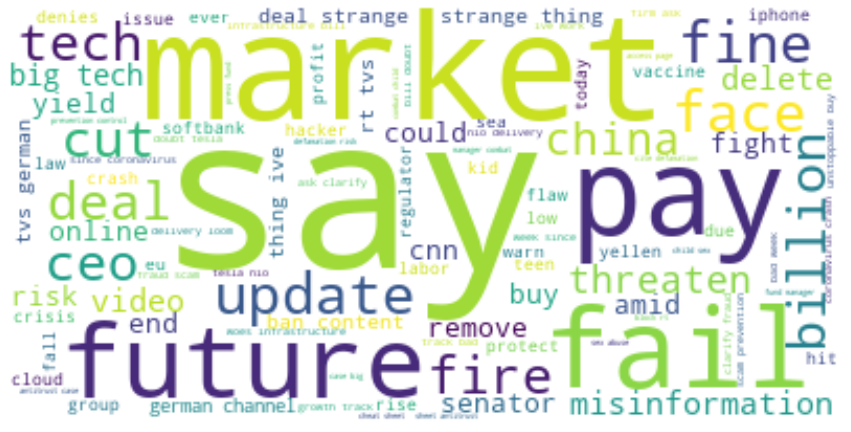

In [ ]:
text= " ".join(review for review in news_data.text_no_num[news_data['label']==0])

stopwords = ['stock','apple','google','facebook', 'amazon', 'dow', 'jones', 'microsoft', 'youtube', 'tiktok', 'instagram','russia']+list(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Fail, say, market, fine, threaten, misinformation and pay are some of the common words found in negative sentiment news.

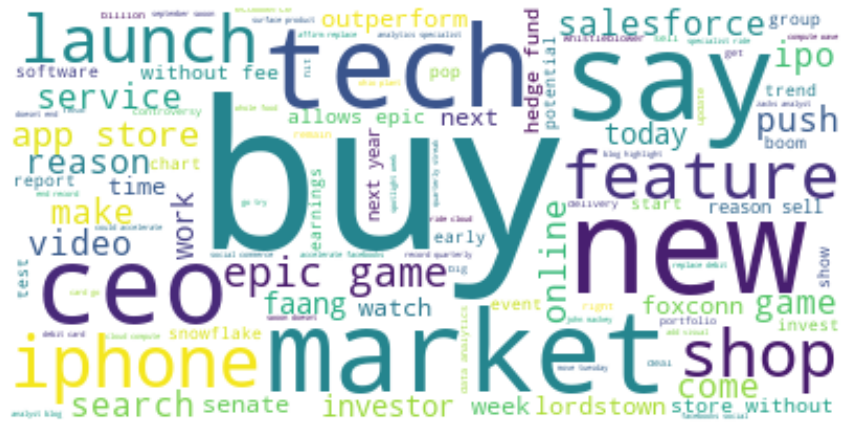

In [ ]:
text= " ".join(review for review in news_data.text_no_num[news_data['label']==1])

stopwords = ['stock', 'apple', 'msft', 'alphabet', 'google', 'facebook', 'amazon', 'dow', 'jones', 'microsoft', 'microsofts', 'nvidia', 'youtube', 'tiktok', 'instagram','russia']+list(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Buy, tech, launch, new, say, market are some of the common words found in neutral sentiment news. Those words detected neutral as it does not seem to cause any positive or negative reaction from readers.

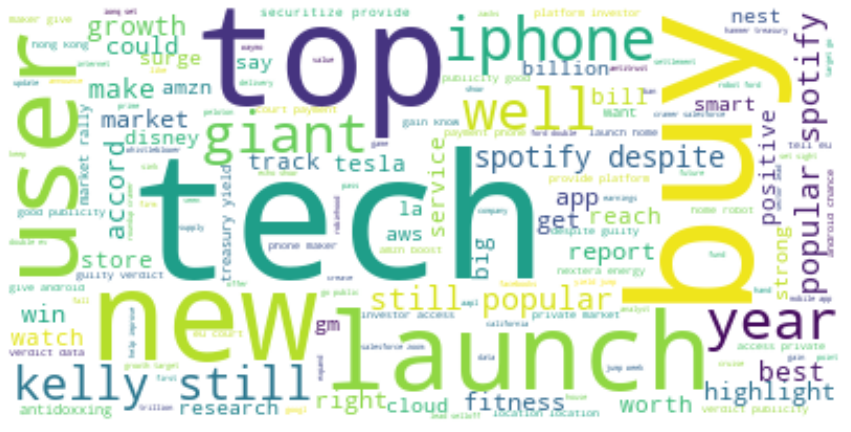

In [ ]:
text= " ".join(review for review in news_data.text_no_num[news_data['label']==2])

stopwords = ['stock', 'apple', 'msft', 'alphabet', 'google', 'facebook', 'amazon', 'dow', 'jones', 'microsoft', 'microsofts', 'nvidia', 'youtube', 'tiktok', 'instagram','russia']+list(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Top, tech, launch, new, buy, launch are some of the common words found in postive sentiment news. Those words intrigue positive sentiment from readers, that could cause raise in stock's price changes.

# Modelling

## Simple RNN

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.BatchNormalization()(x)
x = layers.SimpleRNN(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x) 
outputs = layers.Dense(3, activation='softmax')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_simple_rnn')

In [ ]:
# compile model
model_5.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_5.summary()

Model: "model_simple_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 12)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 12, 128)           512000    
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 128)           512       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 8)            

As seen on above model summary:
- Text Vectorization and Embedding placed right after input layer to preprocess sentences into vector.
- Then followed by simpleRNN layer with 128 nodes
- Batch normalization applied before dense layer in order to reduce overfitting
- There are two dense layer created for hidden layer and output layer. 

In [ ]:
model_5_hist = model_5.fit(X_train,
                           y_train,
                           epochs=50,
                           validation_data=(X_val, y_val))

Epoch 1/50
10/10 [==============================] - 2s 55ms/step - loss: 1.2790 - accuracy: 0.3938 - val_loss: 1.1010 - val_accuracy: 0.3375
Epoch 2/50
10/10 [==============================] - 0s 18ms/step - loss: 0.8036 - accuracy: 0.6406 - val_loss: 1.1198 - val_accuracy: 0.3500
Epoch 3/50
10/10 [==============================] - 0s 18ms/step - loss: 0.6566 - accuracy: 0.7531 - val_loss: 1.1362 - val_accuracy: 0.3500
Epoch 4/50
10/10 [==============================] - 0s 18ms/step - loss: 0.5372 - accuracy: 0.8344 - val_loss: 1.1564 - val_accuracy: 0.3500
Epoch 5/50
10/10 [==============================] - 0s 19ms/step - loss: 0.4580 - accuracy: 0.8719 - val_loss: 1.1720 - val_accuracy: 0.3500
Epoch 6/50
10/10 [==============================] - 0s 18ms/step - loss: 0.3904 - accuracy: 0.8938 - val_loss: 1.1899 - val_accuracy: 0.3625
Epoch 7/50
10/10 [==============================] - 0s 19ms/step - loss: 0.3528 - accuracy: 0.9125 - val_loss: 1.2074 - val_accuracy: 0.2875
Epoch 8/50
10

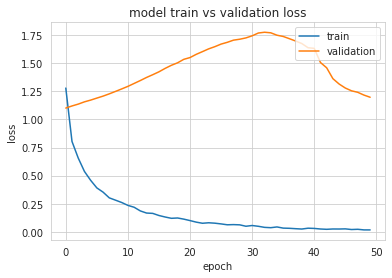

In [ ]:
plt.plot(model_5_hist.history['loss'])
plt.plot(model_5_hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Loss trend in data train and data validation significantly declining. However if we look at the accuracy score, train data already reach max accuracy from the start and validation data gradually inclining from 0.65 to maximum 0.825.

In [ ]:
model_5.evaluate(X_val, y_val)

3/3 [==============================] - 0s 5ms/step - loss: 1.1973 - accuracy: 0.5500


[1.1973085403442383, 0.550000011920929]

In [ ]:
y_pred5 = model_5.predict(X_test)

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred5.argmax(axis=1)))
print("AUC Score:", roc_auc_score(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.23      0.94      0.37        16
           1       0.77      0.42      0.55        40
           2       0.92      0.27      0.42        44

    accuracy                           0.44       100
   macro avg       0.64      0.55      0.45       100
weighted avg       0.75      0.44      0.46       100

AUC Score: 0.7603805916305917


In [ ]:
scores_model = []
scores_model.append({'Model': 'Simple RNN','AUC_Score': roc_auc_score(y_test, y_pred5)})

Class 1 and 2 has good precision and f-1 score considering its number of support, meanwhile class 0 has low score. Overall Accuracy is quite good in 0.70 and its AUC Score is also good at 0.85.

## Fully Connected

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_nlp_fc')

In [ ]:
# compile model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_nlp_fc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 12)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 12, 128)           512000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 387       
Total params: 512,387
Trainable params: 512,387
Non-trainable params: 0
________________________________________________

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('my_model', save_best_only=True, monitor='val_loss', mode='min')

As seen on above model summary:
- Text Vectorization and Embedding placed right after input layer to preprocess sentences into vector.
- Then followed by global average pooling 1D to compute the average value of all values across the entire matrix for each of the input channels
- Dropout 30% applied before dense layer in order to reduce overfitting
- Dense layer created is for output layer.

In [ ]:
model_1_hist = model_1.fit(X_train,
                           y_train,
                           epochs=50,
                           validation_data=(X_val, y_val),
                           callbacks=[earlyStopping, mcp_save])

Epoch 1/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.5579 - val_accuracy: 0.7250
INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Epoch 2/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 0.5580 - val_accuracy: 0.7250
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.5582 - val_accuracy: 0.7250
Epoch 4/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.5583 - val_accuracy: 0.7250
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.5585 - val_accuracy: 0.7250
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 0.5586 - val_accuracy: 0.7250
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 0.5588 - val_accuracy: 0.7250
Epoch 8/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.5589 - val_accuracy: 0.7250
Epoch 9/50
10

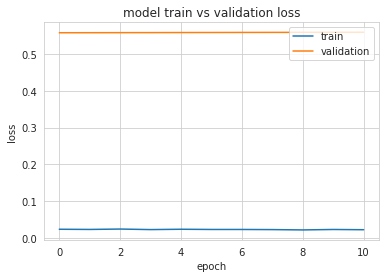

In [ ]:
plt.plot(model_1_hist.history['loss'])
plt.plot(model_1_hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Loss trend in data train and data validation significantly declining. However if we look at the accuracy score, train data already reach max (1.0) accuracy starting from 0.30 in front and validation data gradually inclining from 0.41 to maximum 0.78.

In [ ]:
model_1.evaluate(X_val, y_val)

3/3 [==============================] - 0s 4ms/step - loss: 0.5593 - accuracy: 0.7250


[0.5593001842498779, 0.7250000238418579]

In [ ]:
y_pred = model_1.predict(X_test)

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print("AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.69      0.56        16
           1       0.69      0.62      0.66        40
           2       0.71      0.66      0.68        44

    accuracy                           0.65       100
   macro avg       0.63      0.66      0.63       100
weighted avg       0.67      0.65      0.65       100

AUC Score: 0.8501433982683982


In [ ]:
scores_model.append({'Model': 'Fully Connected','AUC_Score': roc_auc_score(y_test, y_pred)})

Class 1 and 2 has good precision and f-1 score considering its number of support, meanwhile class 0 has low score. Overall Accuracy is quite good in 0.64 and its AUC Score is also good at 0.83.

## LSTM

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = layers.BatchNormalization()(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.BatchNormalization()(x)
x = layers.LSTM(128)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(3, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name="LSTM_model")

In [ ]:
model_2.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 12)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 12, 128)           512000    
_________________________________________________________________
batch_normalization_22 (Batc (None, 12, 128)           512       
_________________________________________________________________
lstm_8 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
batch_normalization_23 (Batc (None, 12, 128)           512       
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               1

As seen on above model summary:
- Text Vectorization and Embedding placed right after input layer to preprocess sentences into vector.
- Then followed by LSTM layer with 128 nodes
- Batch normalization applied before dense layer and LSTM layer2 in order to reduce overfitting
- Dense layer is created for output layer with 3 class. 

In [ ]:
# compile model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2_hist = model_2.fit(X_train,
                           y_train,
                           epochs=20,
                           validation_data=(X_val, y_val))

Epoch 1/20
10/10 [==============================] - 7s 310ms/step - loss: 0.1879 - accuracy: 0.9187 - val_loss: 0.9479 - val_accuracy: 0.7375
Epoch 2/20
10/10 [==============================] - 0s 48ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.8683 - val_accuracy: 0.7500
Epoch 3/20
10/10 [==============================] - 0s 47ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.8100 - val_accuracy: 0.7500
Epoch 4/20
10/10 [==============================] - 0s 49ms/step - loss: 0.0049 - accuracy: 0.9969 - val_loss: 0.7634 - val_accuracy: 0.7500
Epoch 5/20
10/10 [==============================] - 0s 50ms/step - loss: 0.0120 - accuracy: 0.9937 - val_loss: 0.7190 - val_accuracy: 0.7500
Epoch 6/20
10/10 [==============================] - 0s 48ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.6907 - val_accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 1s 51ms/step - loss: 0.0076 - accuracy: 0.9937 - val_loss: 0.6594 - val_accuracy: 0.7500
Epoch 8/20
1

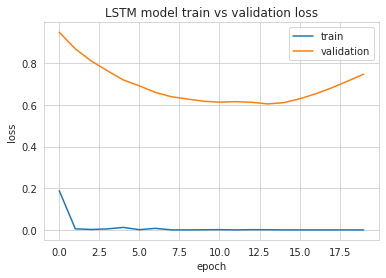

In [ ]:
plt.plot(model_2_hist.history['loss'])
plt.plot(model_2_hist.history['val_loss'])
plt.title('LSTM model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Loss trend in data train rapidly declining until epoch 2 and data validation gradually declining. However if we look at the accuracy score, train data already reach max (1.0) accuracy starting from 0.9 in front and validation data gradually inclining from 0.75 to max 0.81 but then ended up in 0.73.

In [ ]:
model_2.evaluate(X_val, y_val)

3/3 [==============================] - 0s 12ms/step - loss: 0.7470 - accuracy: 0.7875


[0.7469983696937561, 0.7875000238418579]

In [ ]:
y_pred2 = model_2.predict(X_test)

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred2.argmax(axis=1)))
print("AUC Score:", roc_auc_score(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.42      0.81      0.55        16
           1       0.63      0.65      0.64        40
           2       0.75      0.48      0.58        44

    accuracy                           0.60       100
   macro avg       0.60      0.65      0.59       100
weighted avg       0.65      0.60      0.60       100

AUC Score: 0.8493019480519481


In [ ]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc_score(y_test, y_pred2)})

Class 1 and 2 has good precision and f-1 score considering its number of support, meanwhile class 0 has low score. Overall Accuracy is quite good in 0.67 and its AUC Score is also good at 0.85.

## Bidirectional LSTM

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = layers.BatchNormalization()(x)
x = layers.Bidirectional(layers.LSTM(256))(x)
x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(20)(x)
x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model_4 = tf.keras.Model(inputs, outputs, name="LSTM_model2")

In [ ]:
model_4.summary()

Model: "LSTM_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 12)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 12, 128)           512000    
_________________________________________________________________
batch_normalization_25 (Batc (None, 12, 128)           512       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               788480    
_________________________________________________________________
batch_normalization_26 (Batc (None, 512)               2048      
_________________________________________________________________
dense_20 (Dense)             (None, 20)                

As seen on above model summary:
- Text Vectorization and Embedding placed right after input layer to preprocess sentences into vector.
- Then followed by Bidirectional LSTM layer 
- Batch normalization applied before dense layer in order to reduce overfitting
- Dense layer is created for hidden layer and output layer with 3 class. 

In [ ]:
# compile model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_4_hist = model_4.fit(X_train,
                           y_train,
                           epochs=50,
                           validation_data=(X_val, y_val))

Epoch 1/50
10/10 [==============================] - 6s 225ms/step - loss: 0.2186 - accuracy: 0.9219 - val_loss: 0.7917 - val_accuracy: 0.7375
Epoch 2/50
10/10 [==============================] - 1s 122ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.7666 - val_accuracy: 0.7375
Epoch 3/50
10/10 [==============================] - 1s 117ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.7607 - val_accuracy: 0.7875
Epoch 4/50
10/10 [==============================] - 1s 120ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.7570 - val_accuracy: 0.7875
Epoch 5/50
10/10 [==============================] - 1s 120ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.7435 - val_accuracy: 0.7875
Epoch 6/50
10/10 [==============================] - 1s 121ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.7322 - val_accuracy: 0.7875
Epoch 7/50
10/10 [==============================] - 1s 120ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.7211 - val_accuracy: 0.7875
Epoch 

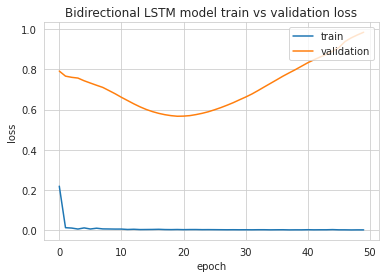

In [ ]:
plt.plot(model_4_hist.history['loss'])
plt.plot(model_4_hist.history['val_loss'])
plt.title('Bidirectional LSTM model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Loss trend in data train rapidly declining until epoch 2 and data validation gradually declining. Validation loss is declining however its accuracy reach max at 0.76 and remain stable until epoch ends. 

In [ ]:
model_4.evaluate(X_val, y_val)

3/3 [==============================] - 0s 32ms/step - loss: 0.9852 - accuracy: 0.7625


[0.985202968120575, 0.762499988079071]

In [ ]:
y_pred4 = model_4.predict(X_test)

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred4.argmax(axis=1)))
print("AUC Score:", roc_auc_score(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.43      0.81      0.57        16
           1       0.71      0.60      0.65        40
           2       0.75      0.61      0.67        44

    accuracy                           0.64       100
   macro avg       0.63      0.68      0.63       100
weighted avg       0.68      0.64      0.65       100

AUC Score: 0.841976911976912


In [ ]:
scores_model.append({'Model': 'Bidirectional LSTM','AUC_Score': roc_auc_score(y_test, y_pred4)})

Class 1 and 2 has good precision and f-1 score considering its number of support. Class 0 shown better score than previous model. Overall Accuracy is quite good at 0.68 and its AUC Score is also good at 0.85.

## GRU

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = layers.BatchNormalization()(x)
x = layers.GRU(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(3, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name="GRU_model")

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
# compile model
model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 12)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 12, 128)           512000    
_________________________________________________________________
batch_normalization_28 (Batc (None, 12, 128)           512       
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
batch_normalization_29 (Batc (None, 64)                256       
_________________________________________________________________
dense_22 (Dense)             (None, 20)                13

As seen on above model summary:
- Text Vectorization and Embedding placed right after input layer to preprocess sentences into vector.
- Then followed by GRU layer 
- Batch normalization applied before dense layer in order to reduce overfitting
- Dense layer is created for hidden layer and output layer with 3 class. 

In [ ]:
model_3_hist = model_3.fit(X_train,
                           y_train,
                           epochs=100,
                           validation_data=(X_val, y_val),
                           callbacks=es_callback)

Epoch 1/100
10/10 [==============================] - 3s 82ms/step - loss: 0.6491 - accuracy: 0.7844 - val_loss: 1.0237 - val_accuracy: 0.7000
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.1783 - accuracy: 0.9563 - val_loss: 0.9702 - val_accuracy: 0.7250
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 0.1223 - accuracy: 0.9750 - val_loss: 0.9341 - val_accuracy: 0.7375
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0746 - accuracy: 0.9844 - val_loss: 0.9066 - val_accuracy: 0.7375
Epoch 5/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0672 - accuracy: 0.9844 - val_loss: 0.8877 - val_accuracy: 0.7125
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0455 - accuracy: 0.9969 - val_loss: 0.8685 - val_accuracy: 0.7250
Epoch 7/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.8487 - val_accuracy: 0.7125
Epoch 

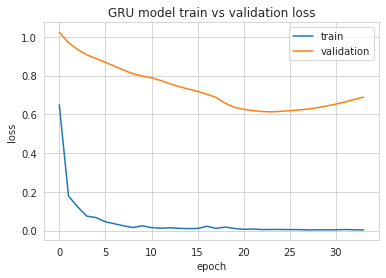

In [ ]:
plt.plot(model_3_hist.history['loss'])
plt.plot(model_3_hist.history['val_loss'])
plt.title('GRU model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Loss trend in data train rapidly declining until epoch 5 and data validation gradually declining. Validation loss is declining and its accuracy reach max at 0.78. 

In [ ]:
y_pred3 = model_3.predict(X_test)

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred3.argmax(axis=1)))
print("AUC Score:", roc_auc_score(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.44      0.69      0.54        16
           1       0.77      0.60      0.68        40
           2       0.70      0.70      0.70        44

    accuracy                           0.66       100
   macro avg       0.64      0.66      0.64       100
weighted avg       0.69      0.66      0.67       100

AUC Score: 0.8269814213564214


In [ ]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc_score(y_test, y_pred3)})

Class 1 and 2 has good precision and f-1 score considering its number of support. Class 0 shown better score other than simple rnn, full conneected and lstm model. Overall Accuracy is quite good in 0.69 and its AUC Score is also good at 0.85.

# Model Evaluation

## ROC-Curve for Negative Sentiment

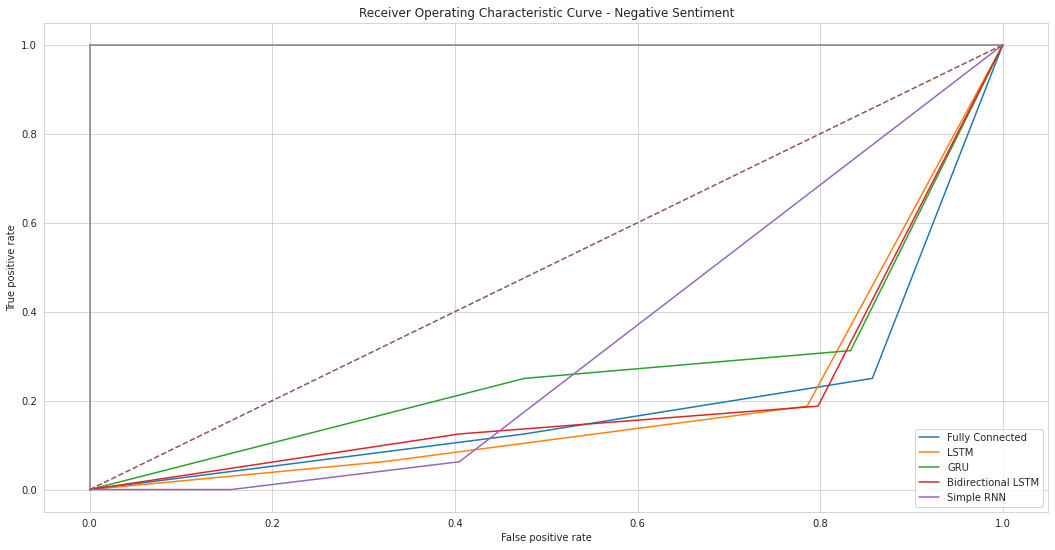

In [ ]:
fc_false_positive_rate,fc_true_positive_rate,fc_threshold = roc_curve(y_test.argmax(axis=1),y_pred.argmax(axis=1), pos_label=0)
lstm_false_positive_rate,lstm_true_positive_rate,lstm_threshold = roc_curve(y_test.argmax(axis=1),y_pred2.argmax(axis=1), pos_label=0)                                                             
gru_false_positive_rate,gru_true_positive_rate,gru_threshold = roc_curve(y_test.argmax(axis=1),y_pred3.argmax(axis=1), pos_label=0)
bdlstm_false_positive_rate,bdlstm_true_positive_rate,bdlstm_threshold = roc_curve(y_test.argmax(axis=1),y_pred4.argmax(axis=1), pos_label=0)
rnn_false_positive_rate,rnn_true_positive_rate,rnn_threshold = roc_curve(y_test.argmax(axis=1),y_pred5.argmax(axis=1), pos_label=0)

sns.set_style('whitegrid')
plt.figure(figsize=(18,9))
plt.title('Receiver Operating Characteristic Curve - Negative Sentiment')
plt.plot(fc_false_positive_rate,fc_true_positive_rate,label='Fully Connected')
plt.plot(lstm_false_positive_rate,lstm_true_positive_rate,label='LSTM')
plt.plot(gru_false_positive_rate,gru_true_positive_rate,label='GRU')
plt.plot(bdlstm_false_positive_rate,bdlstm_true_positive_rate,label='Bidirectional LSTM')
plt.plot(rnn_false_positive_rate,rnn_true_positive_rate,label='Simple RNN')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

ROC Curve for negative sentiment looks poor for all model, having them lower than baseline 0.5.

## ROC Curve for Neutral Sentiment

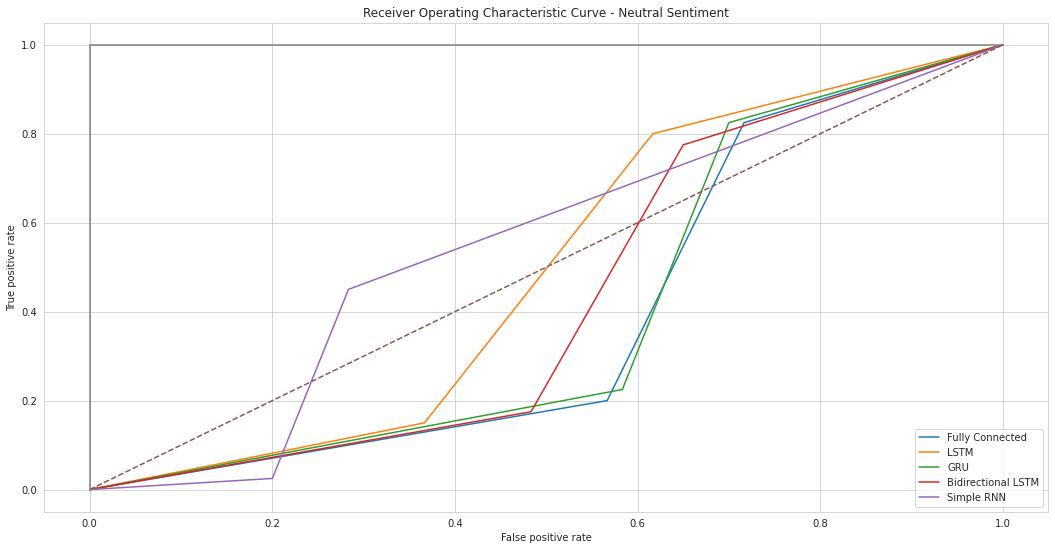

In [ ]:
fc_false_positive_rate,fc_true_positive_rate,fc_threshold = roc_curve(y_test.argmax(axis=1),y_pred.argmax(axis=1), pos_label=1)
lstm_false_positive_rate,lstm_true_positive_rate,lstm_threshold = roc_curve(y_test.argmax(axis=1),y_pred2.argmax(axis=1), pos_label=1)                                                             
gru_false_positive_rate,gru_true_positive_rate,gru_threshold = roc_curve(y_test.argmax(axis=1),y_pred3.argmax(axis=1), pos_label=1)
bdlstm_false_positive_rate,bdlstm_true_positive_rate,bdlstm_threshold = roc_curve(y_test.argmax(axis=1),y_pred4.argmax(axis=1), pos_label=1)
rnn_false_positive_rate,rnn_true_positive_rate,rnn_threshold = roc_curve(y_test.argmax(axis=1),y_pred5.argmax(axis=1), pos_label=1)

sns.set_style('whitegrid')
plt.figure(figsize=(18,9))
plt.title('Receiver Operating Characteristic Curve - Neutral Sentiment')
plt.plot(fc_false_positive_rate,fc_true_positive_rate,label='Fully Connected')
plt.plot(lstm_false_positive_rate,lstm_true_positive_rate,label='LSTM')
plt.plot(gru_false_positive_rate,gru_true_positive_rate,label='GRU')
plt.plot(bdlstm_false_positive_rate,bdlstm_true_positive_rate,label='Bidirectional LSTM')
plt.plot(rnn_false_positive_rate,rnn_true_positive_rate,label='Simple RNN')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

ROC Curve for neutral sentiment also looks poor for all model, having them lower than baseline 0.5.

## ROC-Curve for Positive Sentiment

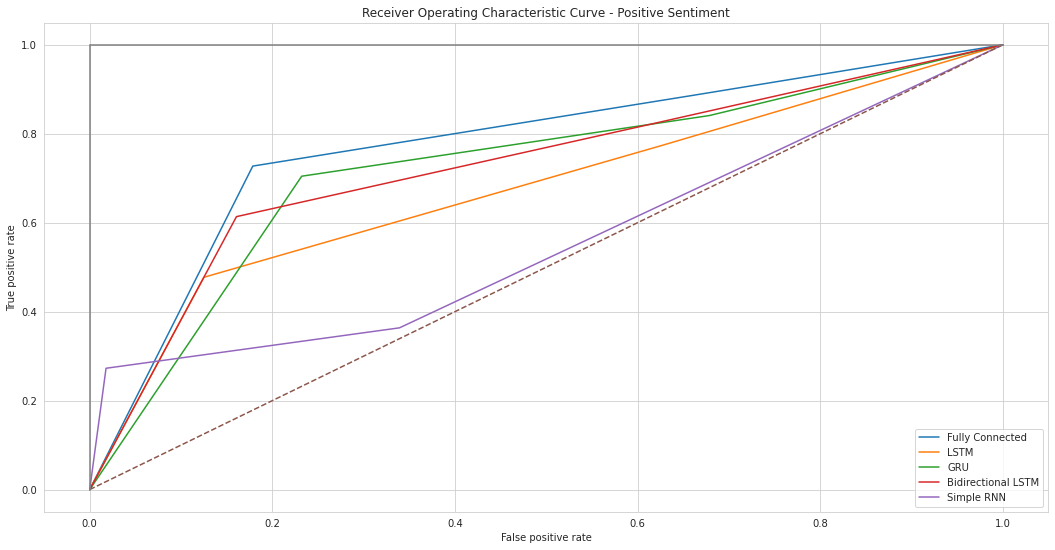

In [ ]:
fc_false_positive_rate,fc_true_positive_rate,fc_threshold = roc_curve(y_test.argmax(axis=1),y_pred.argmax(axis=1), pos_label=2)
lstm_false_positive_rate,lstm_true_positive_rate,lstm_threshold = roc_curve(y_test.argmax(axis=1),y_pred2.argmax(axis=1), pos_label=2)                                                             
gru_false_positive_rate,gru_true_positive_rate,gru_threshold = roc_curve(y_test.argmax(axis=1),y_pred3.argmax(axis=1), pos_label=2)
bdlstm_false_positive_rate,bdlstm_true_positive_rate,bdlstm_threshold = roc_curve(y_test.argmax(axis=1),y_pred4.argmax(axis=1), pos_label=2)
rnn_false_positive_rate,rnn_true_positive_rate,rnn_threshold = roc_curve(y_test.argmax(axis=1),y_pred5.argmax(axis=1), pos_label=2)

sns.set_style('whitegrid')
plt.figure(figsize=(18,9))
plt.title('Receiver Operating Characteristic Curve - Positive Sentiment')
plt.plot(fc_false_positive_rate,fc_true_positive_rate,label='Fully Connected')
plt.plot(lstm_false_positive_rate,lstm_true_positive_rate,label='LSTM')
plt.plot(gru_false_positive_rate,gru_true_positive_rate,label='GRU')
plt.plot(bdlstm_false_positive_rate,bdlstm_true_positive_rate,label='Bidirectional LSTM')
plt.plot(rnn_false_positive_rate,rnn_true_positive_rate,label='Simple RNN')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

ROC Curve for positive sentiment looks good for all model, all AUC Score higher than baseline 0.5. LSTM seem to best model in classifying positive sentiment.

In [ ]:
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.drop_duplicates()
results.drop(axis=0, index=[3])

,Model,AUC_Score
1,Fully Connected,0.858286
2,LSTM,0.855032
4,GRU,0.849479
5,LSTM,0.849302
6,Bidirectional LSTM,0.841977
7,GRU,0.826981
0,Simple RNN,0.760381


Overall, Bidirectional LSTM is the best model according to its AUC Score. Therefore we are trying to improve by adding some dense layer to make the network more complex.

# Model Improvement

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
x = layers.BatchNormalization()(x)
x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(50)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(30)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(3, activation='softmax')(x)
model_6 = tf.keras.Model(inputs, outputs, name="Bidirectional-LSTM-improved")

In [ ]:
# compile model
model_6.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=["accuracy"])

In [ ]:
model_6.summary()

Model: "Bidirectional-LSTM-improved"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 12)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 12, 128)           512000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 12, 256)           263168    
_________________________________________________________________
batch_normalization_31 (Batc (None, 12, 256)           1024      
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               394240    
_________________________________________________________________
batch_normalization_32 (Batc (None, 256

In attempt to make network more complex, we are adding more bidirectional LSTM layer, dense layer and batch normalization layer. Batch normalization is important to prevent model from overfitting.

In [ ]:
model_6_hist = model_6.fit(X_train,
                           y_train,
                           epochs=100,
                           validation_data=(X_val, y_val),
                           callbacks=es_callback)

Epoch 1/100
10/10 [==============================] - 11s 431ms/step - loss: 0.1307 - accuracy: 0.9500 - val_loss: 0.8310 - val_accuracy: 0.7500
Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.7708 - val_accuracy: 0.8000
Epoch 3/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.7478 - val_accuracy: 0.7875
Epoch 4/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.7364 - val_accuracy: 0.7875
Epoch 5/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.7254 - val_accuracy: 0.7625
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.7130 - val_accuracy: 0.7625
Epoch 7/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.7005 - val_accuracy: 0.762

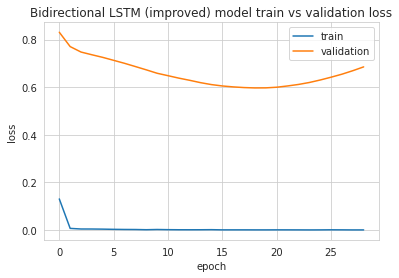

In [ ]:
plt.plot(model_6_hist.history['loss'])
plt.plot(model_6_hist.history['val_loss'])
plt.title('Bidirectional LSTM (improved) model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
y_pred6 = model_6.predict(X_test)

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred6.argmax(axis=1)))
print("AUC Score:", roc_auc_score(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.45      0.81      0.58        16
           1       0.66      0.62      0.64        40
           2       0.73      0.55      0.62        44

    accuracy                           0.62       100
   macro avg       0.61      0.66      0.61       100
weighted avg       0.65      0.62      0.62       100

AUC Score: 0.8486544011544012


AUC Score and loss trend frequently changing everytime we try to fit the data. There are some other time where improved version has better score than previous model.

# Model Saving

In [ ]:
model = keras.models.load_model('my_model')

# Model Inference

In [ ]:
sample_headline = ['Gone in Minutes, Out for Hours: Outage Shakes Facebook']

In [ ]:
prediction1 = model.predict(sample_headline)
prediction1.argmax(axis=1)

array([0])

In this section we are trying to classify sample headline about Facebook recently, and see to what sentiment label it belongs. Turns out, model classify it into negative sentiment (class 0), as expected.

# Conclusion

**EDA Analysis:**

1. Collected news headline during Sept 22 - Oct 3, 2021, have high positive sentiment and low negative sentiment, meanwhile neutral sentiment is in between. Both sentiment is well balanced.
2. For Amazon, Google and Apple, News related to them seems lessen gradually. Sentiment proportion in day by day is similar during that period of time.
3. Microsoft has positive sentiment news sparks on 30 Sept, as an impact from reviewed as top stocks to buy in some article.
3. As for Facebook, Instagram survey seems to be hot topics resulting in positive and negative reaction during 28-30 Sept 2021.

**Model Analysis**

1. All model could classify class 1 and 2 in good precision and f-1 score considering its number of support, meanwhile poorly classify class 0 except for GRU and Bidirectional LSTM.
2. Batch Normalization works better than Layer Normalization and dropout in handling overfitting.
3. However, AUC Score and accuracy continously changing everytime author retrain the model. More dataset is needed to better train the models.
4. Model Optimization on Bidirectional LSTM shows slight improvement than previous model. Author should try another architecture or optimization technique in improving model.
5. Dataset class defined by NLT Vader Sentiment Intensity Analyzer and categorize based on its compound score. Author should recheck each news one by one to ensure its correct sentiment or use another sentiment analyzer in near future.